# Sentiment Analysis and Quality Metrics in Amazon Product Reviews

## Importing Necessary Libraries:

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

In [2]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Text processing 
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## Loading the Dataset

In [4]:
df = pd.read_csv("Reviews.csv")

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.shape

(568454, 10)

In [7]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


## Data Preprocessing

## Data description and each column's relevance:

- Id: This is just an index and not useful for analysis. It can be dropped.
- ProductId: Important to identify reviews related to specific products. Useful for analyzing sentiment per product and performing product-specific aggregations.
- UserId: This is helpful for analyzing behavior patterns across users, and understanding review frequency, or detecting repeat users.
- HelpfulnessNumerator & HelpfulnessDenominator: These indicate how helpful other users found the review. It could be useful for weighting reviews (i.e., reviews with more helpful votes could be considered more reliable).
- Score: The product rating (1–5). Essential for analyzing review sentiment correlations and can be a feature to predict or a label for classification.
- Time: This is useful for time-based analysis, trends, and seasonality (after conversion to a readable format). Keep this column.
- Summary: A brief version of the review. You can use this as an additional text field for sentiment analysis, though it might overlap with the Text.
- Text: The full review text is the most critical feature for sentiment analysis

## Data Cleaning

### Checking for missing values

In [10]:
print(df.isnull().sum())

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


### Here we found a very few missing values in the profilename and summary columns, which we can drop without any issue.

In [11]:
df = df.drop(columns=['Id', 'ProfileName'])

In [12]:
df.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
# Dropping rows with missing values in 'Summary'
df_cleaned = df.dropna(subset=['Summary'])

In [14]:
print(df_cleaned.isnull().sum())

ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


### Checking for Duplicates

In [16]:
duplicates = df_cleaned[df_cleaned.duplicated(subset=['ProductId', 'Text'], keep=False)]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 2152


In [17]:
# Dropping duplicates
df_cleaned = df_cleaned.drop_duplicates(subset=['ProductId', 'Text'])

### Dropping the duplicate rows

In [18]:
duplicates = df_cleaned[df_cleaned.duplicated(subset=['ProductId', 'Text'], keep=False)]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 0


In [19]:
# Verify cleaning
print("Shape after cleaning:", df_cleaned.shape)
print("Missing values after cleaning:\n", df_cleaned.isnull().sum())

Shape after cleaning: (567103, 8)
Missing values after cleaning:
 ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


In [20]:
# Converting the time to datetime format 
df_cleaned['Time'] = pd.to_datetime(df_cleaned['Time'], unit='s')

# Verify the conversion
print(df_cleaned[['Time']].head())

        Time
0 2011-04-27
1 2012-09-07
2 2008-08-18
3 2011-06-13
4 2012-10-21


## Text Preprocessing

### Importing NLTK libraries

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK resources (if not already done)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Defining the preprocessing function

In [36]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Custom stopwords (refined to retain sentiment/topic relevance)
custom_stopwords = stop_words - {"not", "no", "nor", "like", "good", "great", "bad", "worse", 
                                 "excellent", "poor", "love", "hate", "recommend", "product", 
                                 "flavor", "package", "candy"}

# Enhanced preprocessing function
def preprocess_text_v2(text):
    # Convert to lowercase
    text = text.lower()
    
    # Expand contractions and handle negations
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", " not", text)  # doesn't -> does not
    text = re.sub(r"'re", " are", text)  # they're -> they are
    text = re.sub(r"'s", " is", text)    # it's -> it is
    text = re.sub(r"'ll", " will", text)  # I'll -> I will
    text = re.sub(r"'ve", " have", text)  # I've -> I have
    text = re.sub(r"'d", " would", text)  # I'd -> I would
    text = re.sub(r"i'm", "i am", text)   # I'm -> I am
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # Remove special characters but retain basic punctuation
    text = re.sub(r'[^\w\s.,]', '', text)
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in custom_stopwords]
    
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Rejoin words while preserving sentence structure
    cleaned_text = ' '.join(words)
    
    return cleaned_text

# Apply the preprocessing function to the dataset
df['Cleaned_Text'] = df['Text'].apply(preprocess_text_v2)

# Preview the cleaned dataset
print(df[['Text', 'Cleaned_Text']].head(20))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yeshw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Text  \
0                                                                                                                                                                                                                    

In [35]:
import pandas as pd

# Adjust display settings to show full text
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.max_rows', None)     # Show all rows (optional)

# Display the DataFrame
df[['Text', 'Cleaned_Text']].head(20) # Adjust the number of rows to preview


,Text,Cleaned_Text
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,bought several vitality canned dog food product found good quality . product look like stew processed meat smell better . labrador finicky appreciates product better .
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanut ... peanut actually small sized unsalted . not sure error vendor intended represent product jumbo .
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.","confection around century . light , pillowy citrus gelatin nut case filbert . cut tiny square liberally coated powdered sugar . tiny mouthful heaven . not chewy , flavorful . highly recommend yummy treat . familiar story c.s . lewis lion , witch , wardrobe treat seduces edmund selling brother sister witch ."
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,looking secret ingredient robitussin believe found . got addition root beer extract ordered good made cherry soda . flavor medicinal .
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.","great taffy great price . wide assortment yummy taffy . delivery quick . taffy lover , deal ."
5,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.","got wild hair taffy ordered five pound bag . taffy enjoyable many flavor watermelon , root beer , melon , peppermint , grape , etc . complaint bit much redblack licoriceflavored piece not particular favorite . , kid , husband , lasted two week would recommend brand taffy delightful treat ."
6,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, Fralinger's. Would highly recommend this candy! I served it at a beach-themed party and everyone loved it!","saltwater taffy great flavor soft chewy . candy individually wrapped well . none candy stuck together , happen expensive version , fralinger . would highly recommend candy served beachthemed party everyone loved"
7,This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!,taffy good . soft chewy . flavor amazing . would definitely recommend buying . satisfying
8,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too,right mostly sprouting cat eat grass . love . rotate around wheatgrass rye
9,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount

In [39]:
df.columns

Index(['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text', 'Cleaned_Text', 'Review_Length',
       'Negation_Count'],
      dtype='object')

In [49]:
df_cleaned = df.drop(columns=['Negation_Count'])


In [50]:
df_cleaned.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Review_Length
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,bought several vitality canned dog food product found good quality . product look like stew processed meat smell better . labrador finicky appreciates product better .,23
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanut ... peanut actually small sized unsalted . not sure error vendor intended represent product jumbo .,19
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.","confection around century . light , pillowy citrus gelatin nut case filbert . cut tiny square liberally coated powdered sugar . tiny mouthful heaven . not chewy , flavorful . highly recommend yummy treat . familiar story c.s . lewis lion , witch , wardrobe treat seduces edmund selling brother sister witch .",41
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,looking secret ingredient robitussin believe found . got addition root beer extract ordered good made cherry soda . flavor medicinal .,18
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.","great taffy great price . wide assortment yummy taffy . delivery quick . taffy lover , deal .",13


# Exploratory Data Analysis

In [51]:
# Exploring unique values in the Score column
unique_scores = df_cleaned['Score'].unique()
print("Unique Scores:", unique_scores)

Unique Scores: [5 1 4 2 3]


### There are 5 unique scores/ ratings as 1,2,3,4,5.

In [52]:
# Checking the distribution of scores
score_distribution = df_cleaned['Score'].value_counts()
print("Score Distribution:\n", score_distribution)

Score Distribution:
 Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64


### The distribution of the scores/ratings across the dataset vary widely as 5 has most of the distributions whereas 4,1,3, and 2 has minimal ratings in a descending order starting from 4 respectively.

In [53]:
# Display some unique values from the Summary and Text columns
print("Unique Summaries:\n", df_cleaned['Summary'].unique()[:10])  # Display first 10 unique summaries
print("Unique Texts:\n", df_cleaned['Text'].unique()[:10])        # Display first 10 unique texts

Unique Summaries:
 ['Good Quality Dog Food' 'Not as Advertised' '"Delight" says it all'
 'Cough Medicine' 'Great taffy' 'Nice Taffy'
 'Great!  Just as good as the expensive brands!' 'Wonderful, tasty taffy'
 'Yay Barley' 'Healthy Dog Food']
Unique Texts:
 ['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'
 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'
 'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavor

In [54]:
-------------start wroking from here


SyntaxError: invalid syntax (3848798966.py, line 1)

### Distribution of ratings score

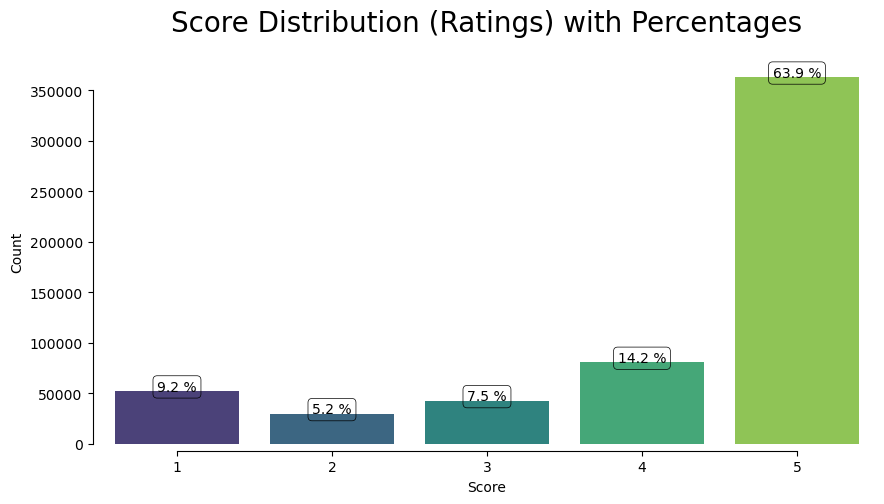

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot with percentages for Score distribution
plt.figure(figsize=(10,5))
ax = sns.countplot(x=df_cleaned['Score'], palette='viridis')
total = float(len(df_cleaned))  # Get the total number of reviews

# Annotate each bar with percentage
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 75, 
            '{:1.1f} %'.format((height / total) * 100), 
            ha="center", bbox=dict(facecolor='none', edgecolor='black', 
                                   boxstyle='round', linewidth=0.5))

# Set plot title and axis labels
ax.set_title('Score Distribution (Ratings) with Percentages', fontsize=20, y=1.05)
ax.set_xlabel('Score')
ax.set_ylabel('Count')

# Customize the axes and appearance
sns.despine(right=True)
sns.despine(offset=5, trim=True)

# Show plot
plt.show()


### From the plot, it is clear that the majority of the reviews are skewed towards positive reviews (with a Score of 5, representing 63.9% of the total), while lower scores are much less frequent. This imbalance in the distribution of scores can indeed introduce bias in your sentiment analysis model.

- Bias in Imbalanced Datasets:
Over-representation of Positive Sentiment: Since most of the reviews have a high score (5), the model might become biased toward predicting positive sentiments more frequently, potentially ignoring or underperforming on negative or neutral reviews.
Under-representation of Negative Sentiment: The lower ratings (1, 2) are under-represented, so the model might not learn enough patterns from those, which can hurt its performance in predicting negative sentiment.
Approaches to Address Bias:
Resampling Techniques:

- Undersampling: Reduce the number of samples from the over-represented class (i.e., score = 5) to balance the dataset.
Oversampling: Duplicate or generate more samples (e.g., using SMOTE) for the under-represented classes (i.e., score = 1, 2, etc.).
- Stratified Sampling:
When splitting your data for training and testing, use stratified sampling to maintain the same class distribution in both sets. This ensures that the model sees a similar imbalance in training and testing data.

- Class Weighting:
When using classification algorithms, you can assign class weights to the loss function, giving higher importance to the minority classes (lower scores) so that the model pays more attention to them during training.

- Balanced Subset for Analysis:
If you're conducting aspect-based sentiment analysis or specific analyses where balance is critical, you can take a balanced subset of the data with an equal number of reviews from each score. However, this could result in data loss and reduced diversity, so it should be done cautiously.

### Since I am going to perform Aspect-based sentiment analysis, I would like to go with Balanced Subset for Analysis. 

In [56]:
import pandas as pd

# Get the minimum count of reviews across all ratings
min_count = df_cleaned['Score'].value_counts().min()

# Create a balanced dataset by sampling 'min_count' reviews from each rating category
df_balanced = df_cleaned.groupby('Score').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Check the distribution of ratings in the balanced dataset
print(df_balanced['Score'].value_counts())

Score
1    29769
2    29769
3    29769
4    29769
5    29769
Name: count, dtype: int64


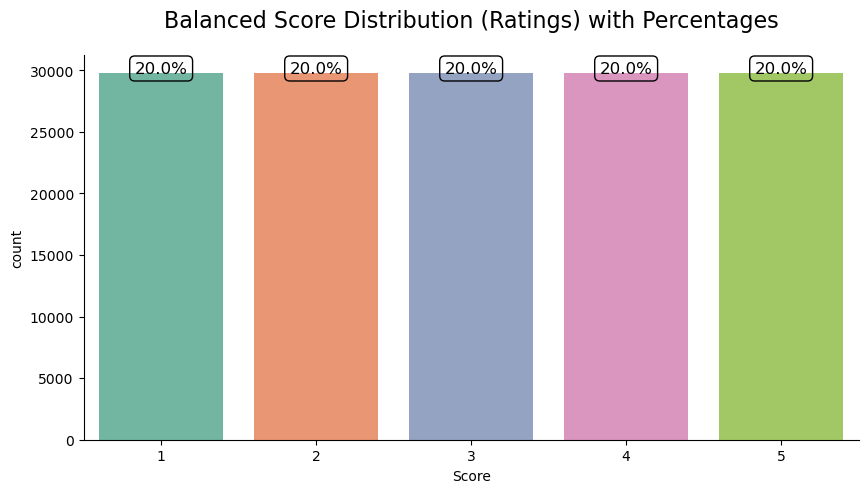

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the 'Score' for the balanced dataset
plt.figure(figsize=(10,5))
ax = sns.countplot(x=df_balanced['Score'], palette='Set2')

# Calculate the total number of rows
total = float(len(df_balanced))

# Add percentage annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, '{:1.1f}%'.format((height/total) * 100), 
            ha="center", fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))

# Set title and display the plot
ax.set_title('Balanced Score Distribution (Ratings) with Percentages', fontsize=16, y=1.05)
sns.despine(right=True)
plt.show()


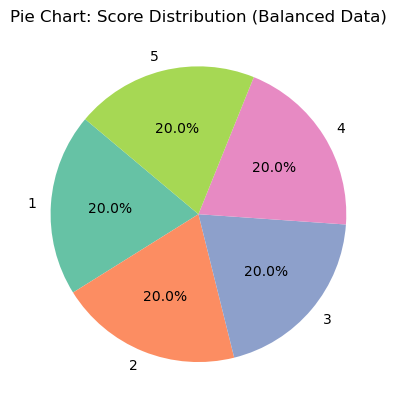

In [58]:
# Pie chart for the balanced data
score_values = df_balanced['Score'].value_counts()
plt.pie(score_values, labels=score_values.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Pie Chart: Score Distribution (Balanced Data)')
plt.show()

## Now that we have a balanced dataset, We can go ahead with the analysis.

In [59]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148845 entries, 0 to 148844
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               148845 non-null  object
 1   UserId                  148845 non-null  object
 2   HelpfulnessNumerator    148845 non-null  int64 
 3   HelpfulnessDenominator  148845 non-null  int64 
 4   Score                   148845 non-null  int64 
 5   Time                    148845 non-null  int64 
 6   Summary                 148819 non-null  object
 7   Text                    148845 non-null  object
 8   Cleaned_Text            148845 non-null  object
 9   Review_Length           148845 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 11.4+ MB


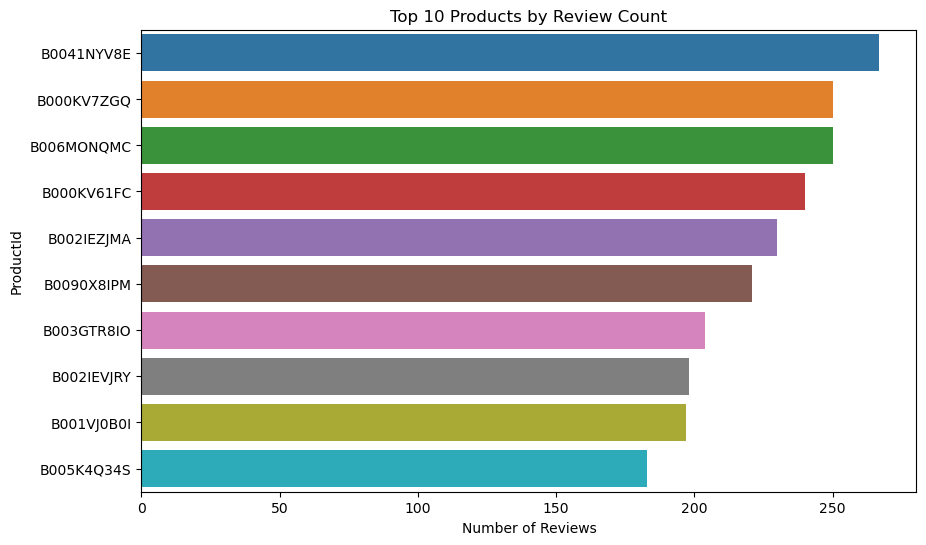

In [60]:
# Top Product Details
top_products = df_balanced['ProductId'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Review Count')
plt.xlabel('Number of Reviews')
plt.show()


In [61]:
# Helpfulness of reviews

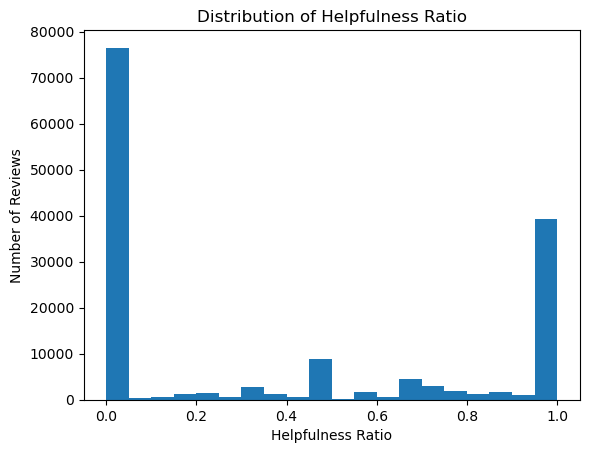

In [62]:
df_balanced['HelpfulnessRatio'] = df_balanced['HelpfulnessNumerator'] / (df_balanced['HelpfulnessDenominator'] + 1e-10)  # Avoid division by zero
plt.hist(df_balanced['HelpfulnessRatio'], bins=20)
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Number of Reviews')
plt.show()


### Review length analysis

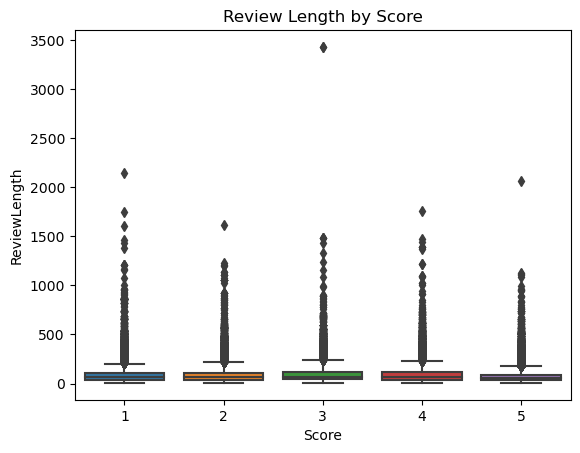

In [63]:
df_balanced['ReviewLength'] = df_balanced['Text'].apply(lambda x: len(x.split()))
sns.boxplot(x='Score', y='ReviewLength', data=df_balanced)
plt.title('Review Length by Score')
plt.show()


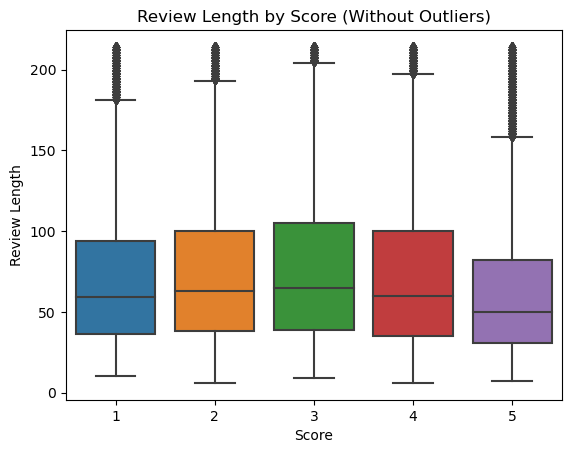

In [64]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_balanced['ReviewLength'].quantile(0.25)
Q3 = df_balanced['ReviewLength'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = 0
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_no_outliers = df_balanced[(df_balanced['ReviewLength'] >= lower_bound) & (df_balanced['ReviewLength'] <= upper_bound)]

# Plot again without outliers
sns.boxplot(x='Score', y='ReviewLength', data=df_no_outliers)
plt.title('Review Length by Score (Without Outliers)')
plt.xlabel('Score')
plt.ylabel('Review Length')
plt.show()


In [65]:
df_no_outliers.shape

(139402, 12)

In [66]:
# Review time analysis

C:\Users\yeshw\AppData\Local\Temp\ipykernel_12040\1222872130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['ReviewDate'] = pd.to_datetime(df_no_outliers['Time'], unit='s')


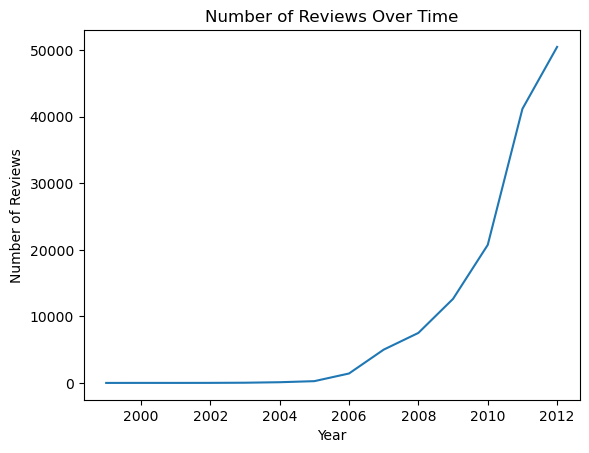

In [67]:
df_no_outliers['ReviewDate'] = pd.to_datetime(df_no_outliers['Time'], unit='s')
df_balanced.groupby(df_no_outliers['ReviewDate'].dt.year).size().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()


### Here the reviews have picked up since 2005 and increased linearly till 2008, and later people started reviewing the items more and we can see an exponential increase from 2008 to 2012.

In [68]:
df_no_outliers.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Review_Length,HelpfulnessRatio,ReviewLength,ReviewDate
0,B0044QANE4,A11ETZNY80TQ2E,2,3,1,1298592000,Smells solvent-y,"I bought this rice in the ten pound bag at my local indian market for twelve dollars. I bought it over my usual brand b/c I thought my toddler would like the cute zipper top zebra bag. Bad decision, upon rinsing the rice I noticed a solvent smell, like kerosene. I thought I'd cook some to see if it went away, or what would happen. It still smelled and I could taste the kerosene-y smell. I threw it all away and will go back to my regular brand.","bought rice ten pound bag local indian market twelve dollar . bought usual brand bc thought toddler would like cute zipper top zebra bag . bad decision , upon rinsing rice noticed solvent smell , like kerosene . thought would cook see went away , would happen . still smelled could taste keroseney smell . threw away go back regular brand .",54,0.666667,88,2011-02-25
1,B000HQNE2S,A23U1DSRY1KMGS,0,3,1,1204934400,Liquid Pepper,"If you like liquid black pepper you will love this soup. I dont like drinking liquid pepper and have no idea how I'm goig to use the rest of this bad product. Trust me , boil water and dump in the contents of you pepper shaker into it and youve got their Hot and Sour soup.","like liquid black pepper love soup . dont like drinking liquid pepper no idea goig use rest bad product . trust , boil water dump content pepper shaker youve got hot sour soup .",32,0.000000,56,2008-03-08
2,B006N3IE6A,A1TG50OP3GC5W6,0,0,1,1307059200,Poor quality Kcups,I love the taste but have found that many of the cups explode!! The glue on the side of the cup becomes undone and then the cup explodes. Very hard to clean up. Do not think I will buy this brand again!,love taste found many cup explode glue side cup becomes undone cup explodes . hard clean . not think buy brand,20,0.000000,42,2011-06-03
3,B000G1CG50,A1IL3GYDL8QCYH,1,1,1,1337644800,chummies no longer yummy,"My dog used to love these, and ate them for years. I ordered 2 bags for the pet sitter to feed her while I have been away but she noticed my dog refused to eat any. When she checked the ingredient label she saw they are no longer pure salmon but are now using fillers! I would send this food back but the return window will close while I am not home.","dog used love , ate year . ordered 2 bag pet sitter feed away noticed dog refused eat . checked ingredient label saw no longer pure salmon using filler would send food back return window close not home .",35,1.000000,72,2012-05-22
4,B005052LEI,A29YDSKJAUXHIT,0,1,1,1350950400,halo cat food,"They were supposed to send 12 cans, they sent one and credited my account. Fussy cat and she did not eat it.","supposed send 12 can , sent one credited account . fussy cat not eat .",11,0.000000,22,2012-10-23


C:\Users\yeshw\AppData\Local\Temp\ipykernel_12040\1968518640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['ReviewYear'] = df_no_outliers['ReviewDate'].dt.year


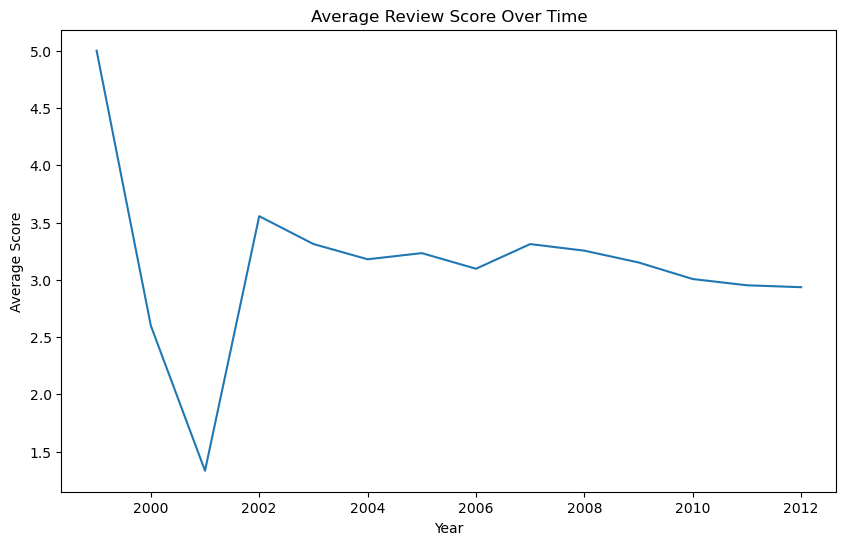

In [70]:
# Calculating the average score per year
df_no_outliers['ReviewYear'] = df_no_outliers['ReviewDate'].dt.year
avg_score_by_year = df_no_outliers.groupby('ReviewYear')['Score'].mean()

# Plotting the trend
plt.figure(figsize=(10,6))
avg_score_by_year.plot()
plt.title('Average Review Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.show()


### Word frequency analysis 

In [72]:
from collections import Counter

# Combine all words into one list
all_words = ' '.join(df_no_outliers['Cleaned_Text']).split()

# Get word frequencies
word_freq = Counter(all_words)

# Display the 20 most common words
common_words = word_freq.most_common(20)
print("Most Common Words:")
for word, freq in common_words:
    print(f"{word}: {freq}")


Most Common Words:
.: 552239
,: 368190
not: 178076
like: 67773
taste: 57932
product: 45599
good: 45554
would: 45169
flavor: 44651
one: 41504
coffee: 41229
tea: 29871
great: 26733
love: 26426
get: 26165
food: 25748
really: 23345
no: 23161
much: 21717
dog: 21426


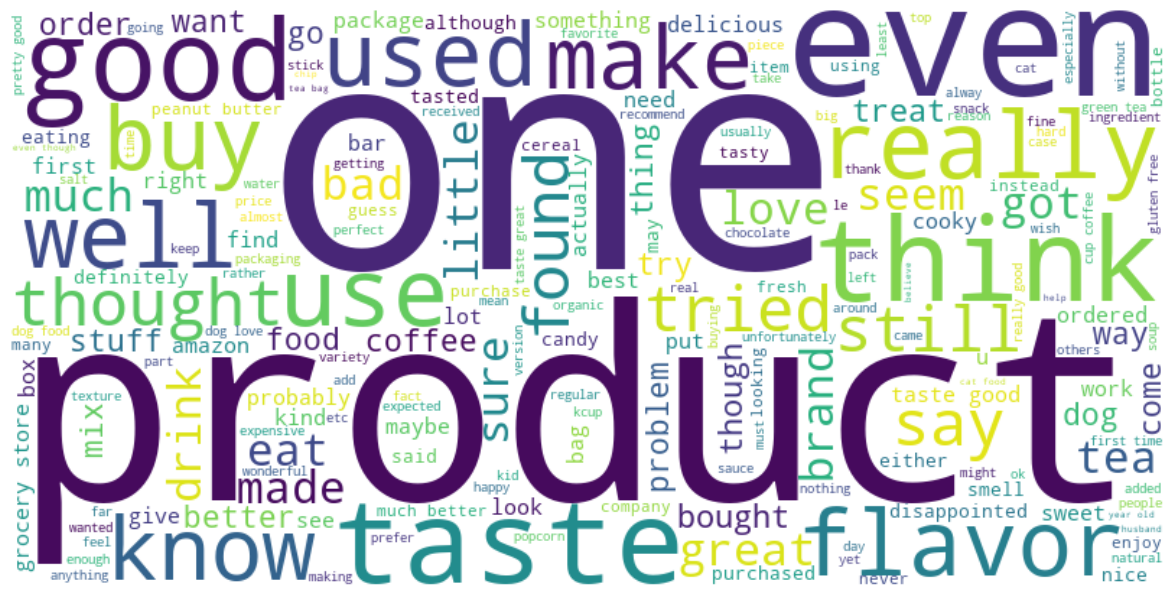

In [73]:
from wordcloud import WordCloud

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Display the word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [74]:
from wordcloud import WordCloud

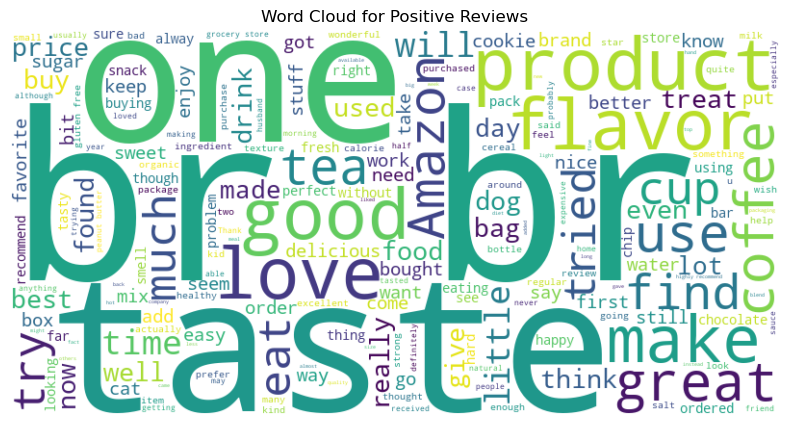

In [75]:
# Positive Reviews (Score 4 and 5)
positive_text = ' '.join(df_no_outliers[df_no_outliers['Score'] >= 4]['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()



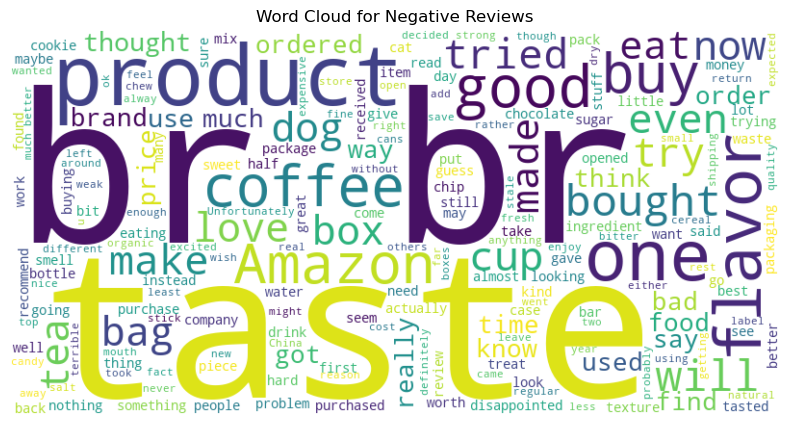

In [76]:
# Negative Reviews (Score 1 and 2)
negative_text = ' '.join(df_no_outliers[df_no_outliers['Score'] <= 2]['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

## Sentiment Labeling
### Since I am performing sentiment analysis, we need to create sentiment labels.
Define Sentiment Labels Based on 'Score':
- Positive: Scores 4 and 5
- Neutral: Score 3
- Negative: Scores 1 and 2

Sentiment
Positive    56027
Negative    55924
Neutral     27451
Name: count, dtype: int64


C:\Users\yeshw\AppData\Local\Temp\ipykernel_12040\1576563826.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Sentiment'] = df_no_outliers['Score'].apply(label_sentiment)


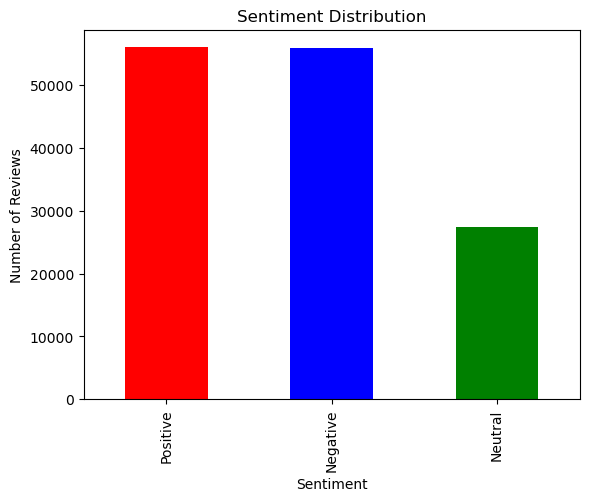

In [77]:
def label_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

df_no_outliers['Sentiment'] = df_no_outliers['Score'].apply(label_sentiment)

# Verify the sentiment distribution
print(df_no_outliers['Sentiment'].value_counts())

# Plot the sentiment distribution
df_no_outliers['Sentiment'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


## Helpfulness ratio v/s score

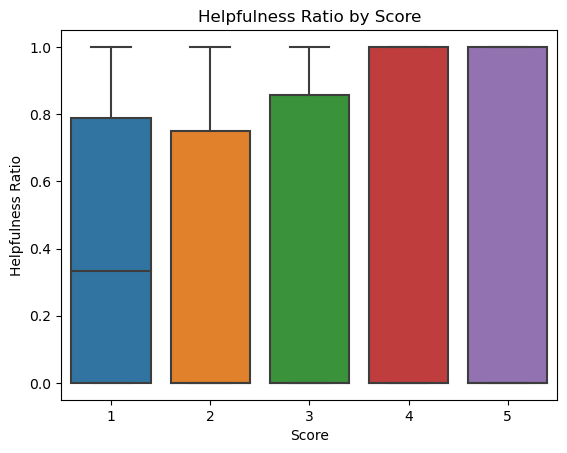

In [78]:
sns.boxplot(x='Score', y='HelpfulnessRatio', data=df_no_outliers)
plt.title('Helpfulness Ratio by Score')
plt.xlabel('Score')
plt.ylabel('Helpfulness Ratio')
plt.show()


## The average review score over time has seen fluctuations over the years.

In [79]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [80]:
# Top 20 words for score 5 (positive)
positive_reviews = df_no_outliers[df_no_outliers['Score'] == 5]['Text']
top_words_positive = get_top_n_words(positive_reviews, 20)
print("Top words in positive reviews:", top_words_positive)

Top words in positive reviews: [('br', 18907), ('great', 9900), ('like', 9611), ('good', 8431), ('love', 7410), ('just', 6817), ('coffee', 6608), ('taste', 6521), ('product', 6335), ('tea', 5971), ('flavor', 5952), ('amazon', 4966), ('food', 4957), ('best', 4415), ('really', 4129), ('ve', 3887), ('time', 3802), ('use', 3735), ('price', 3642), ('tried', 3499)]


In [81]:
# Top 20 words for score 1 (negative)
negative_reviews = df_no_outliers[df_no_outliers['Score'] == 1]['Text']
top_words_negative = get_top_n_words(negative_reviews, 20)
print("Top words in negative reviews:", top_words_negative)

Top words in negative reviews: [('br', 23142), ('like', 12692), ('product', 11301), ('taste', 9177), ('just', 7536), ('coffee', 6367), ('amazon', 5701), ('good', 5560), ('food', 5472), ('buy', 5015), ('flavor', 4927), ('don', 4687), ('tea', 4294), ('bought', 3707), ('tried', 3693), ('box', 3680), ('bad', 3484), ('really', 3456), ('dog', 3304), ('time', 3224)]


In [83]:
# Top 20 words for score 5 (positive)
positive_reviews = df_no_outliers[df_no_outliers['Score'] == 5]['Text']
top_words_positive = get_top_n_words(positive_reviews, 20)
print("Top words in positive reviews:", top_words_positive)

Top words in positive reviews: [('great', 9900), ('like', 9611), ('good', 8431), ('love', 7410), ('just', 6817), ('coffee', 6608), ('taste', 6521), ('product', 6335), ('tea', 5971), ('flavor', 5952), ('amazon', 4966), ('food', 4957), ('best', 4415), ('really', 4129), ('ve', 3887), ('time', 3802), ('use', 3735), ('price', 3642), ('tried', 3499), ('don', 3313)]


In [84]:
# Top 20 words for score 1 (negative)
negative_reviews = df_no_outliers[df_no_outliers['Score'] == 1]['Text']
top_words_negative = get_top_n_words(negative_reviews, 20)
print("Top words in negative reviews:", top_words_negative)

Top words in negative reviews: [('like', 12692), ('product', 11301), ('taste', 9177), ('just', 7536), ('coffee', 6367), ('amazon', 5701), ('good', 5560), ('food', 5472), ('buy', 5015), ('flavor', 4927), ('don', 4687), ('tea', 4294), ('bought', 3707), ('tried', 3693), ('box', 3680), ('bad', 3484), ('really', 3456), ('dog', 3304), ('time', 3224), ('did', 3138)]


### Successfully removed "br" from the text

In [85]:
# Save the DataFrame to a CSV file
df_no_outliers.to_csv('Reviews_2.csv', index=False)


# Preparing Data for Modeling
Now, let's prepare the data for building machine learning models

Split the Data into Training and Testing Sets:

In [87]:
from sklearn.model_selection import train_test_split

X = df_no_outliers['Cleaned_Text']
y = df_no_outliers['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Model Building
With the data prepared, you're ready to build and evaluate machine learning models.

# Logistic Regression:

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the model
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Logistic Regression Performance:
              precision    recall  f1-score   support

    Negative       0.74      0.82      0.78     11302
     Neutral       0.53      0.33      0.41      5489
    Positive       0.77      0.83      0.80     11090

    accuracy                           0.73     27881
   macro avg       0.68      0.66      0.66     27881
weighted avg       0.71      0.73      0.71     27881

Accuracy: 0.7287


# Naive Bayes

In [90]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")


Naive Bayes Performance:
              precision    recall  f1-score   support

    Negative       0.69      0.83      0.75     11302
     Neutral       0.63      0.09      0.16      5489
    Positive       0.69      0.84      0.76     11090

    accuracy                           0.69     27881
   macro avg       0.67      0.59      0.56     27881
weighted avg       0.68      0.69      0.64     27881

Accuracy: 0.6893


# SVM

In [91]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")


C:\Users\yeshw\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVM Performance:
              precision    recall  f1-score   support

    Negative       0.74      0.83      0.78     11302
     Neutral       0.55      0.30      0.39      5489
    Positive       0.76      0.84      0.80     11090

    accuracy                           0.73     27881
   macro avg       0.68      0.65      0.65     27881
weighted avg       0.71      0.73      0.71     27881

Accuracy: 0.7273


# So far, SVM, and Logistic regression has performed well compared to Naive Bayes Model.

# I would like to work more on using deep learning models and NLP models like BERT.